# Examining Cloud Information in the RRFS Ensemble

shawn.s.murdzek@noaa.gov

Machine: Jet  
Environment: adb_graphics

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pyDA_utils.plot_model_data as pmd
import numpy as np
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
from importlib import reload
pmd = reload(pmd)

# Data Ingest and Data Manipulation Cells

In [3]:
"""
Read in ensemble output

NOTE: This should really use open_mfdataset, but that function requires Dask, which is not installed in the
adb_graphics environment. The pygraf environment has Dask, but is missing netCDF4, which is required for
pyDA_utils.plot_model_data
"""

# UPP output for each ensemble member
#parent = '/lfs1/BMC/wrfruc/chunhua/Feb2022_retro/Ens_GDAS_noGF_cloud/v0.6.2/prod/rrfs_conus_3km_ensda.20220202/10'
parent_ens = '/mnt/lfs4/BMC/wrfruc/murdzek/RRFS_Ens_Cloud_DA/Feb2022_retro/Ens_GDAS_SDLVDL_noGF_cloud1/v0.6.2/prod/rrfs_conus_3km_ensda.20220201/08'
prslev_fnames_ens = [parent_ens + '/mem%04d/rrfs.t08z.prslev.f001.conus_3km.grib2' % i for i in range(1, 31)]
natlev_fnames_ens = [parent_ens + '/mem%04d/rrfs.t08z.natlev.f001.conus_3km.grib2' % i for i in range(1, 31)]
prslev_vars_ens = ['HGT_P0_L215_GLC0']

# UPP output for deterministic run
#parent_det = '/mnt/lfs4/BMC/wrfruc/murdzek/RRFS_Ens_Cloud_DA/RRFSret_Feb2022_Ens_GDAS_SDLVDL_noGF/rrfs.20220202/10'
#prslev_fname_det = parent_dt + '/rrfs.t10z.prslev.f001.conus_3km.grib2'
#natlev_fname_det = parent_dt + '/rrfs.t10z.natlev.f001.conus_3km.grib2'
#prslev_vars_det = ['HGT_P0_L215_GLC0']

###

# Read in output
ens_output = []
for prs_f, nat_f in zip(prslev_fnames_ens, natlev_fnames_ens):
    print('reading %s' % nat_f.split('/')[-2])
    ens_output.append(xr.open_dataset(nat_f, engine='pynio'))
    prs_ds = xr.open_dataset(prs_f, engine='pynio')
    for v in prslev_vars_ens:
        ens_output[-1][v] = prs_ds[v].copy()

#print('reading deterministic run')
#det_output = xr.open_dataset(natlev_fname_det, engine='pynio')
#prs_ds = xr.open_dataset(prslev_fname_det, engine='pynio')
#for v in prslev_vars:
#    det_output[v] = prs_ds[v].copy()

reading mem0001
reading mem0002
reading mem0003
reading mem0004
reading mem0005
reading mem0006
reading mem0007
reading mem0008
reading mem0009
reading mem0010
reading mem0011
reading mem0012
reading mem0013
reading mem0014
reading mem0015
reading mem0016
reading mem0017
reading mem0018
reading mem0019
reading mem0020
reading mem0021
reading mem0022
reading mem0023
reading mem0024
reading mem0025
reading mem0026
reading mem0027
reading mem0028
reading mem0029
reading mem0030


In [4]:
"""
Subset ensemble output for the desired region
"""

# Domain
min_lon = -78
max_lon = -73
min_lat = 38
max_lat = 42
z_ind = [4]

# Domain (DelMarVa Pennisula)
min_lon = -76.5
max_lon = -75
min_lat = 38
max_lat = 40
z_ind = [4]

# Domain (South TX)
min_lon = -100
max_lon = -98.5
min_lat = 27.5
max_lat = 29.5
z_ind = [10]

###

# Determine indices for the x and y dimensions by finding the indices of gridpoints closest to the corners
iind = np.zeros(4, dtype=int)
jind = np.zeros(4, dtype=int)
n = 0
for lon in [min_lon, max_lon]:
    for lat in [min_lat, max_lat]:
        iind[n], jind[n] = np.unravel_index(np.argmin((ens_output[0]['gridlon_0'] - lon)**2 + 
                                                      (ens_output[0]['gridlat_0'] - lat)**2), 
                                            ens_output[0]['gridlon_0'].shape)
        n = n + 1
xstart = np.amin(np.where(ens_output[0]['gridlon_0'] >= min_lon)[1])
xend = np.amax(np.where(ens_output[0]['gridlon_0'] <= max_lon)[1])
ystart = np.amin(np.where(ens_output[0]['gridlat_0'] >= min_lat)[0])
yend = np.amax(np.where(ens_output[0]['gridlat_0'] <= max_lat)[0])

# Create subset DataSet
ens_subset_output = []
for ds in ens_output:
    ens_subset_output.append(ds.sel(xgrid_0=slice(np.amin(jind), np.amax(jind)), 
                                    ygrid_0=slice(np.amin(iind), np.amax(iind)), 
                                    lv_HYBL2=z_ind))

print('Shape of subset =', ens_subset_output[0]['TMP_P0_L105_GLC0'].shape)

Shape of subset = (1, 76, 51)


In [5]:
"""
Compute background error covariance (BEC) matrix
"""

# Variables to include in BEC matrix (assumed to be 3D)
bec_vars = ['TMP_P0_L105_GLC0', 'SPFH_P0_L105_GLC0', 'TCDC_P0_L105_GLC0']

# Thin points in horizontal dimensions
thin = 1

###

if 'ens_subset_output' in locals().keys():
    loop_list = ens_subset_output
else:
    loop_list = ens_output

# Create state vectors
len_state_vect = np.sum(np.array([loop_list[0][v][:, ::thin, ::thin].size for v in bec_vars]))
state_matrix = {'data':np.zeros([len_state_vect, len(loop_list)]),
                'vars':np.concatenate([np.array([v]*loop_list[0][v][:, ::thin, ::thin].size) for v in bec_vars])}
for i, ds in enumerate(loop_list):
    state_matrix['data'][:, i] = np.concatenate([np.ravel(ds[v][:, ::thin, ::thin]) for v in bec_vars])
state_matrix['mean'] = np.mean(state_matrix['data'], axis=1)
state_matrix['errors'] = state_matrix['data'] - state_matrix['mean'][:, np.newaxis]

# Compute the covariance and correlation matrix
bec_corr = np.corrcoef(state_matrix['data'])
bec_cov = np.cov(state_matrix['data'])

/contrib/miniconda3/4.5.12/envs/adb_graphics/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/contrib/miniconda3/4.5.12/envs/adb_graphics/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


# Plotting Cells

plotting mem 1 (time = 20231130 22:30:01)
plotting mem 2 (time = 20231130 22:30:02)
plotting mem 3 (time = 20231130 22:30:04)
plotting mem 4 (time = 20231130 22:30:05)
plotting mem 5 (time = 20231130 22:30:06)
plotting mem 6 (time = 20231130 22:30:07)
plotting mem 7 (time = 20231130 22:30:08)
plotting mem 8 (time = 20231130 22:30:08)
plotting mem 9 (time = 20231130 22:30:09)
plotting mem 10 (time = 20231130 22:30:10)
plotting mem 11 (time = 20231130 22:30:12)
plotting mem 12 (time = 20231130 22:30:13)
plotting mem 13 (time = 20231130 22:30:13)
plotting mem 14 (time = 20231130 22:30:15)
plotting mem 15 (time = 20231130 22:30:16)
plotting mem 16 (time = 20231130 22:30:17)
plotting mem 17 (time = 20231130 22:30:18)
plotting mem 18 (time = 20231130 22:30:19)
plotting mem 19 (time = 20231130 22:30:20)
plotting mem 20 (time = 20231130 22:30:21)
plotting mem 21 (time = 20231130 22:30:22)
plotting mem 22 (time = 20231130 22:30:23)
plotting mem 23 (time = 20231130 22:30:24)
plotting mem 24 (tim

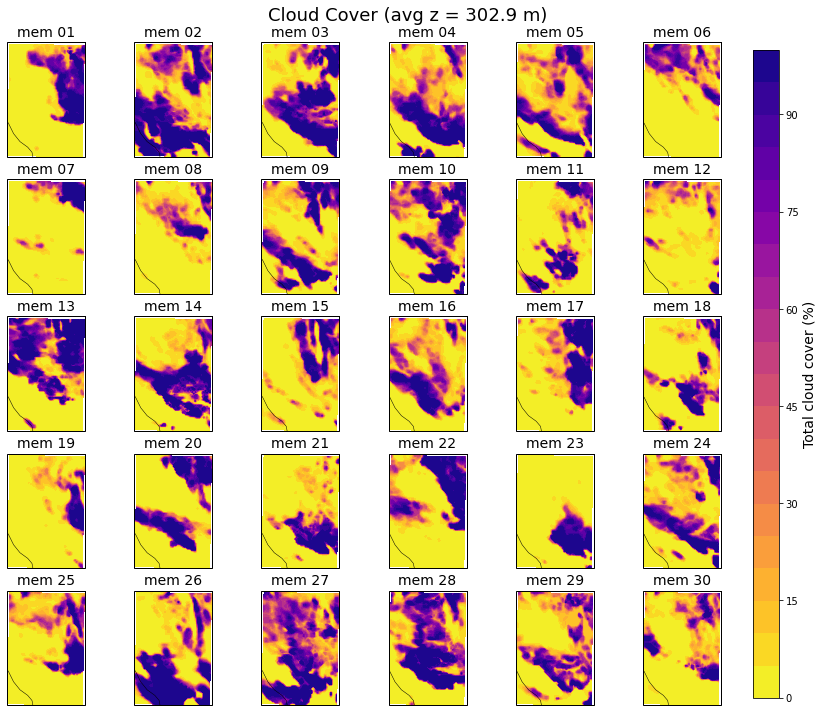

In [7]:
"""
Make horizontal cross section postage stamp plots
"""

# Field name and colorbar limits/colormap. Set klvl to NaN if 2D field
upp_field = 'HGT_P0_L215_GLC0'
save_fname = 'postage_stamp_ceil_TX.png'
title = 'Legacy Ceiling Diagnostic'
klvl = np.nan
cmap = 'plasma'
clevels = np.arange(0, 1000.1, 100)
extend = 'max'

upp_field = 'TCDC_P0_L105_GLC0'
save_fname = 'postage_stamp_cloud_cover.png'
title = 'Cloud Cover'
klvl = 0
cmap = 'plasma_r'
clevels = np.arange(0, 100.1, 5)
extend = 'neither'

###

# Make plot
start = dt.datetime.now()
fig = plt.figure(figsize=(12, 10))
nrows = 5
ncols = 6
if 'ens_subset_output' in locals().keys():
    loop_list = ens_subset_output
else:
    loop_list = ens_output
for i, mem_output in enumerate(loop_list):
    stime = dt.datetime.now()
    print('plotting mem %d (time = %s)' % ((i+1), stime.strftime('%Y%m%d %H:%M:%S')))
    plot_obj = pmd.PlotOutput([mem_output], 'upp', fig, nrows, ncols, i+1)
    plot_obj.contourf(upp_field, cbar=False, ingest_kw={'zind':[klvl]}, 
                      cntf_kw={'cmap':cmap, 'levels':clevels, 'extend':extend})
    plot_obj.config_ax(grid=False)
    plot_obj.set_lim(min_lat, max_lat, min_lon, max_lon)
    plot_obj.ax.set_title('mem %02d' % (i+1), size=14)
    
cb_ax = fig.add_axes([0.9, 0.02, 0.03, 0.9])
cbar = plt.colorbar(plot_obj.cax, cax=cb_ax, orientation='vertical', aspect=35)
cbar.set_label('%s%s (%s)' % (plot_obj.metadata['contourf0']['interp'], 
                              plot_obj.metadata['contourf0']['name'], 
                              plot_obj.metadata['contourf0']['units']), size=14)
plt.subplots_adjust(left=0.01, bottom=0.01, right=0.89, top=0.93, hspace=0.2, wspace=0.02)
plt.suptitle('%s (avg z = %.1f m)' % (title, np.mean(loop_list[0]['HGT_P0_L105_GLC0'][klvl, :, :] -
                                                     loop_list[0]['HGT_P0_L1_GLC0'])), size=18)
plt.savefig(save_fname)

print('elapsed time = %.2f min' % ((dt.datetime.now() - start).total_seconds() / 60.))

plotting TMP_P0_L105_GLC0
plotting SPFH_P0_L105_GLC0
plotting TCDC_P0_L105_GLC0


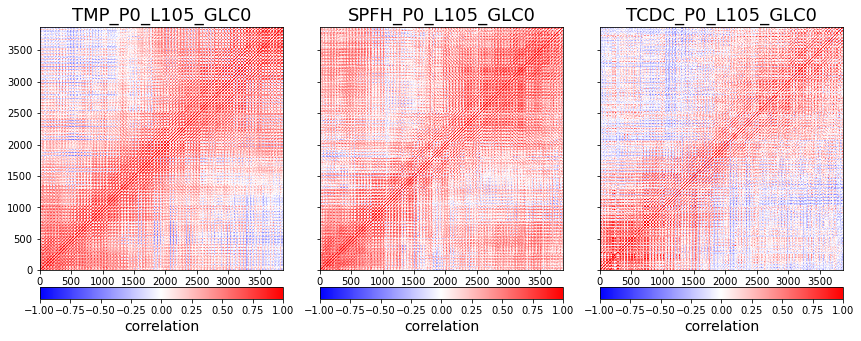

In [25]:
"""
Plot BEC Matrices for Each Variable
"""

save_fname = 'bec_raw_TX.png'

###

fig, axes = plt.subplots(nrows=1, ncols=len(bec_vars), sharex=True, sharey=True, figsize=(12, 6))
plt.subplots_adjust(left=0.06, bottom=0.00, right=0.99, top=0.95, wspace=0.15)
for i, v in enumerate(bec_vars):
    print('plotting %s' % v)
    ax = axes[i]
    ax.set_aspect('equal')
    idx = np.where(state_matrix['vars'] == v)[0]
    bec_subset = bec_corr[idx[0]:idx[-1]+1, idx[0]:idx[-1]+1]
    cax = ax.pcolormesh(np.arange(len(idx)), np.arange(len(idx)), bec_subset, cmap='bwr', vmin=-1, vmax=1)
    cbar = plt.colorbar(cax, ax=ax, orientation='horizontal', pad=0.04)
    cbar.set_label('correlation', size=14)
    ax.set_title(v, size=18)

plt.savefig(save_fname)

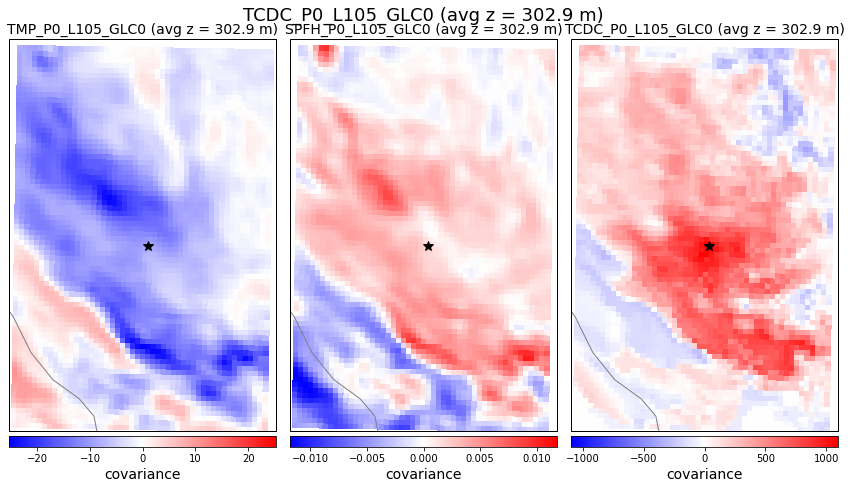

In [26]:
"""
Plot Spatial Distributions of BECs For a Particular Gridpoint and Variable
"""

# Coordinate of point to plot BECs in relation to (this is the "target" point)
lat = 28.4369
lon = -99.2350
target_klvl = 0
var = 'TCDC_P0_L105_GLC0'
plot_klvl = 0
save_fname = 'BEC_spatial_dist_TX.png'

###

# Determine gridpoint closest to the target (lat, lon) coordinate
lat_all = loop_list[0]['gridlat_0'].values
lon_all = loop_list[0]['gridlon_0'].values
target_i, target_j = np.unravel_index(np.argmin((lat_all - lat)**2 + (lon_all - lon)**2), lon_all.shape)

# Determine indices corresponding with the target variable and location
target_var_idx = np.where(state_matrix['vars'] == var)[0]
target_idx = target_var_idx[0] + np.ravel_multi_index([[target_klvl], [target_i], [target_j]], 
                                                      loop_list[0][var].shape)
bec_vect = bec_cov[target_idx, :]

# Determine average heights for the target variable and plotting variables
target_z = np.mean(loop_list[0]['HGT_P0_L105_GLC0'][target_klvl, :, :] - loop_list[0]['HGT_P0_L1_GLC0'])
plot_z = np.mean(loop_list[0]['HGT_P0_L105_GLC0'][plot_klvl, :, :] - loop_list[0]['HGT_P0_L1_GLC0'])

# Make plot
fig = plt.figure(figsize=(12, 7.5))
for i, v in enumerate(bec_vars):
    ax = fig.add_subplot(1, len(bec_vars), i+1, projection=ccrs.LambertConformal())
    
    # Extract BECs
    plot_var_idx = np.where(state_matrix['vars'] == v)[0]
    bec2d = np.reshape(bec_vect[0, plot_var_idx], loop_list[0][v].shape)[plot_klvl, :, :]
    maxval = max([np.amax(bec2d), -np.amin(bec2d)])
    
    cax = ax.pcolormesh(lon_all, lat_all, bec2d, cmap='bwr', vmin=-maxval, vmax=maxval,
                        transform=ccrs.PlateCarree())
    ax.plot(lon_all[target_i, target_j], lat_all[target_i, target_j], 'k*', ms=10, transform=ccrs.PlateCarree())
    
    ax.coastlines('50m')
    borders = cfeature.NaturalEarthFeature(category='cultural',
                                           scale='50m',
                                           facecolor='none',
                                           name='admin_1_states_provinces')
    ax.add_feature(borders, lw=1, edgecolor='gray')
    ax.set_extent([min_lon, max_lon, min_lat, max_lat])
    ax.set_title('%s (avg z = %.1f m)' % (v, plot_z), size=14)
    
    cbar = plt.colorbar(cax, ax=ax, orientation='horizontal', aspect=25, pad=0.01)
    cbar.set_label('covariance', size=14)

plt.subplots_adjust(left=0.02, bottom=0.05, right=0.98, top=0.95, wspace=0.05)
plt.suptitle('%s (avg z = %.1f m)' % (var, target_z), size=18)
plt.savefig(save_fname)

plotting TMP_P0_L105_GLC0
plotting SPFH_P0_L105_GLC0
plotting TCDC_P0_L105_GLC0


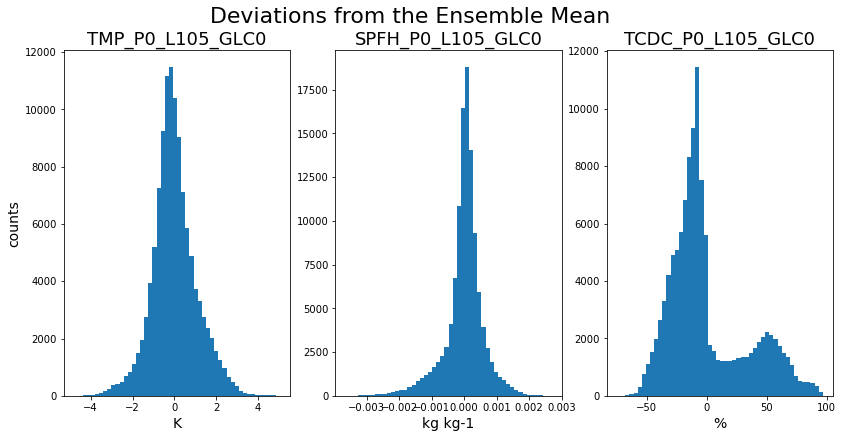

In [46]:
"""
Plot Histograms of Deviations from Ensemble Mean
"""

save_fname = 'error_hist_TX.png'

###

fig, axes = plt.subplots(nrows=1, ncols=len(bec_vars), figsize=(12, 6))
plt.subplots_adjust(left=0.1, bottom=0.08, right=0.99, top=0.88, wspace=0.2)
for i, v in enumerate(bec_vars):
    print('plotting %s' % v)
    ax = axes[i]
    idx = np.where(state_matrix['vars'] == v)[0]
    ax.hist(state_matrix['errors'][idx].flatten(), bins=50)
    ax.set_title(v, size=18)
    ax.set_xlabel(ens_output[0][v].attrs['units'], size=14)

axes[0].set_ylabel('counts', size=14)
plt.suptitle('Deviations from the Ensemble Mean', size=22)
plt.savefig(save_fname)

plotting mem 1 (time = 20231130 22:30:38)
plotting mem 2 (time = 20231130 22:30:47)
plotting mem 3 (time = 20231130 22:30:54)
plotting mem 4 (time = 20231130 22:31:01)
plotting mem 5 (time = 20231130 22:31:09)
plotting mem 6 (time = 20231130 22:31:16)
plotting mem 7 (time = 20231130 22:31:23)
plotting mem 8 (time = 20231130 22:31:30)
plotting mem 9 (time = 20231130 22:31:37)
plotting mem 10 (time = 20231130 22:31:43)
plotting mem 11 (time = 20231130 22:31:51)
plotting mem 12 (time = 20231130 22:31:57)
plotting mem 13 (time = 20231130 22:32:04)
plotting mem 14 (time = 20231130 22:32:11)
plotting mem 15 (time = 20231130 22:32:18)
plotting mem 16 (time = 20231130 22:32:24)
plotting mem 17 (time = 20231130 22:32:31)
plotting mem 18 (time = 20231130 22:32:38)
plotting mem 19 (time = 20231130 22:32:45)
plotting mem 20 (time = 20231130 22:32:52)
plotting mem 21 (time = 20231130 22:32:59)
plotting mem 22 (time = 20231130 22:33:06)
plotting mem 23 (time = 20231130 22:33:13)
plotting mem 24 (tim

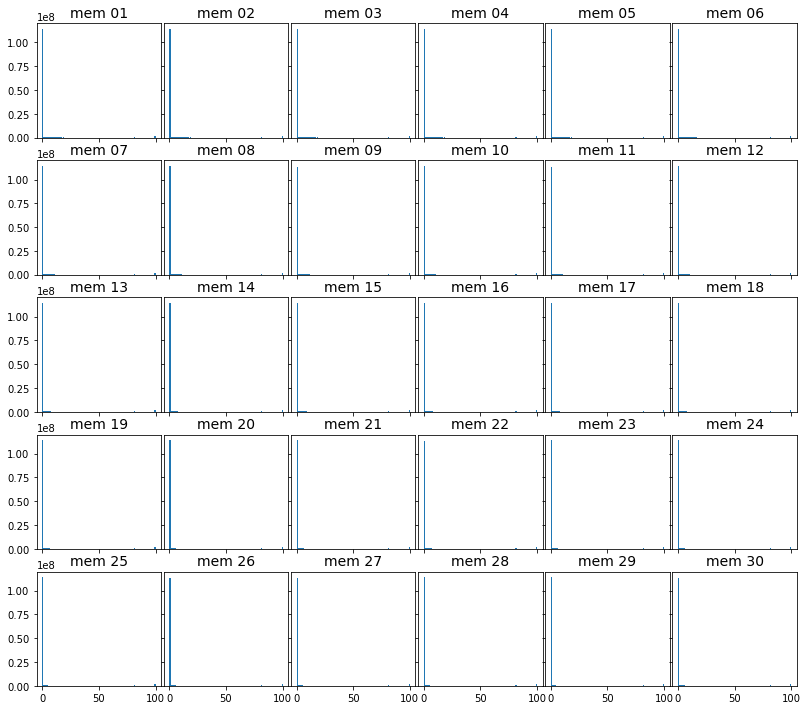

In [8]:
"""
Make horizontal cross section postage stamp plots for ENTIRE DOMAIN
"""

# Field name, output file name, and number of bins
upp_field = 'TCDC_P0_L105_GLC0'
save_fname = 'postage_stamp_cloud_cover_PDF.png'
bins = 100

###

# Make plot
start = dt.datetime.now()
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(12, 10), sharex=True, sharey=True)
plt.subplots_adjust(left=0.01, bottom=0.01, right=0.89, top=0.93, hspace=0.2, wspace=0.02)
loop_list = ens_output
for i, mem_output in enumerate(loop_list):
    stime = dt.datetime.now()
    print('plotting mem %d (time = %s)' % ((i+1), stime.strftime('%Y%m%d %H:%M:%S')))
    ax = axes[int(i/6), i%6]
    ax.hist(mem_output[upp_field].values.flatten(), bins=bins)
    ax.set_title('mem %02d' % (i+1), size=14)
    
plt.savefig(save_fname)

print('elapsed time = %.2f min' % ((dt.datetime.now() - start).total_seconds() / 60.))

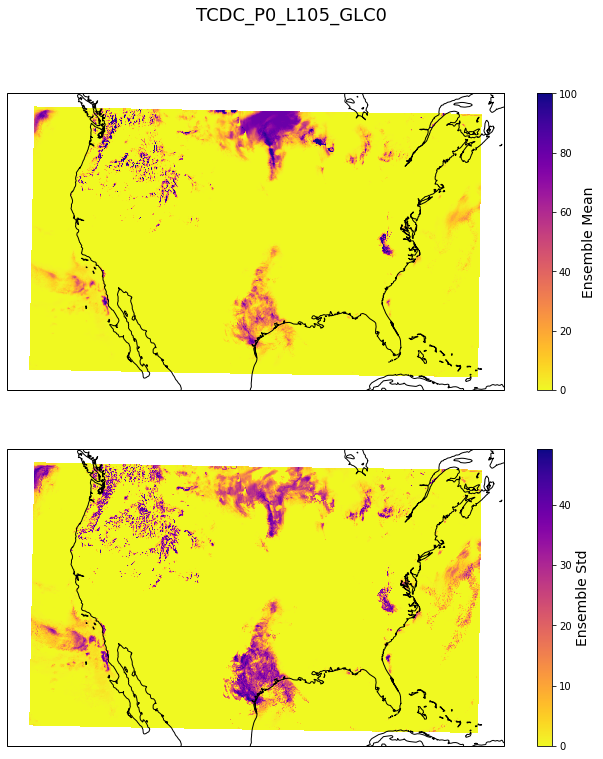

In [11]:
"""
Plot ensemble mean and standard deviation across all of CONUS
"""

# Field name, output file name, and vertical level (set to NaN for 2D field)
upp_field = 'TCDC_P0_L105_GLC0'
save_fname = 'postage_stamp_cloud_cover_PDF.png'
klvl = 10
cmap = 'plasma_r'

###

# Construct array with dimensions (ens, x, y) for easier plotting
loop_list = ens_output
plot_array = np.zeros([len(ens_output), 
                       ens_output[0][upp_field][klvl, :, :].shape[0], 
                       ens_output[0][upp_field][klvl, :, :].shape[1]])
for i, mem_output in enumerate(loop_list):
    plot_array[i, :, :] = mem_output[upp_field][klvl, :, :].values

# Create plot
fig = plt.figure(figsize=(12, 12))
for i, (fct, ttl) in enumerate(zip([np.mean, np.std], ['Ensemble Mean', 'Ensemble Std'])):
    ax = fig.add_subplot(2, 1, i+1, projection=ccrs.LambertConformal())
    ax.coastlines('50m')
    cax = ax.pcolormesh(ens_output[0]['gridlon_0'], ens_output[0]['gridlat_0'], fct(plot_array, axis=0), 
                        transform=ccrs.PlateCarree(), cmap=cmap)
    cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
    cbar.set_label(ttl, size=14)

plt.suptitle(upp_field, size=18)
plt.savefig(save_fname)